In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [112]:
data_path = 'data/'

# train_csv_file_path = data_path + 'train_ship_segmentations_v2.csv'
train_csv_file_path = data_path + 'train_ship_segmentations_v2_clean.csv'
# train_csv_file_path = data_path + 'demo.csv'
# train_csv_file_path = data_path + 'demo_clean.csv'
train_image_path = data_path + 'train_v2/'

In [113]:
def load_csv(path):
    return tf.data.experimental.make_csv_dataset(
        path,
        batch_size=1, # required
        column_names=['ImageId', 'EncodedPixels'],
        num_epochs=1,
    )

train_csv = load_csv(train_csv_file_path)

# for batch in train_csv.take(1):
#     print(batch)

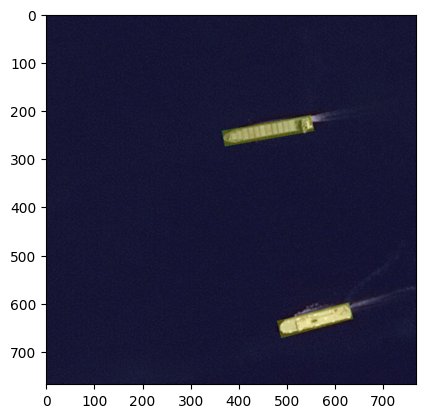

In [135]:
IMG_HEIGHT = 768
IMG_WIDTH = 768

def process_img(file):
    img = tf.io.read_file(train_image_path + file)
    img = tf.io.decode_jpeg(img, channels=3)
    return img

def decode_label_mask(encoded_pixels, image_height, image_width):
    mask = tf.zeros(image_height * image_width, dtype=tf.uint8)

    # Convert string to integer tensor
    pairs = tf.strings.to_number(tf.strings.split(encoded_pixels), out_type=tf.int32)

    # Iterate over pairs and update mask
    for i in range(0, len(pairs), 2):
        start = pairs[i] - 1
        run_length = pairs[i + 1]

        indices = tf.range(start, start + run_length)
        updates = tf.ones(run_length, dtype=tf.uint8)
        mask = tf.tensor_scatter_nd_update(mask, indices=tf.expand_dims(indices, axis=1), updates=updates)

    return  tf.transpose(tf.reshape(mask, (image_height, image_width)))

def process_label(label):
    return decode_label_mask(label, IMG_HEIGHT, IMG_WIDTH)

def process_batch(csv_item):
    X = process_img(csv_item['ImageId'])
    y = process_label(csv_item['EncodedPixels'])
    return X, y

def plot_ds_element(background, overlay):
    fig, ax = plt.subplots()
    plt.imshow(background)
    ax.imshow(overlay, alpha=0.3)

train_ds = train_csv.unbatch().map(process_batch)

for item, label in train_ds.take(1):
    plot_ds_element(item, label)
